# bengaliai-cv19

## コンペ概要

### データ概要

Trainのデータサイズ : ２０万  
Testのデータサイズ : 手元で参照できるのはたった12枚 (LBはもっと多くのデータで計算している -> **計算時間に気を付ける必要がある**) 

- image_id : 画像ファイルとの紐付け
- grapheme_root : 1つ目のラベル
- vowel_diacritic : 2つ目のラベル
- consonant_diacritic : 3つ目のラベル
- grapheme : 画像で与えられた実際の文字 (使わない)

**要は画像から、3つのラベル当てるコンペ**  
class_map_df は、名前の通りラベルの対応を示すdf

### メモ

- Testの入力が少しTrainと異なるのでそこは注意
- データはそれなりにimbalance
  - consonant_diacriticは半分以上0...
  - 0はノーラベルってこと..?
  - grapheme_rootはクラスが多すぎる
- コンペの鍵は、grapheme_rootのミスっているやつか...?
  - post processの出番..?
  - https://www.kaggle.com/c/bengaliai-cv19/discussion/130503
- Discussionまとめ
  - https://www.kaggle.com/c/bengaliai-cv19/discussion/127976
- とりあえずHengさんについていくのが良さそうか
  - CVはどうする...?
    - Multiなんとか使うべきか...?
  - Lossも工夫するべきか...?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATA_PATH = '../dataset/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH +  'test.csv')
class_map_df = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_sub_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [3]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [6]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [7]:
print(f'Size of training data: {train_df.shape}')
print(f'Size of test data: {test_df.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


## 各ラベルのEDA

In [8]:
grapheme_root_df = class_map_df[class_map_df['component_type'] == 'grapheme_root']
vowel_diacritic_df = class_map_df[class_map_df['component_type'] == 'vowel_diacritic']
consonant_diacritic_df = class_map_df[class_map_df['component_type'] == 'consonant_diacritic']

In [9]:
# grapheme_root のクラスがやけに多い
print(f'class of grapheme_root: {grapheme_root_df.shape}')
print(f'class of vowel_diacritic: {vowel_diacritic_df.shape}')
print(f'class of consonant_diacritic: {consonant_diacritic_df.shape}')

class of grapheme_root: (168, 3)
class of vowel_diacritic: (11, 3)
class of consonant_diacritic: (7, 3)


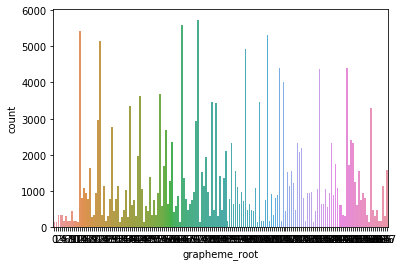

In [10]:
# Trainの分布を見てみる
sns.countplot(x="grapheme_root", data=train_df)

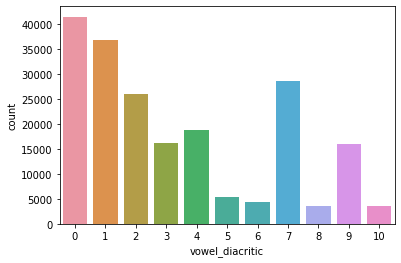

In [11]:
sns.countplot(x="vowel_diacritic", data=train_df)

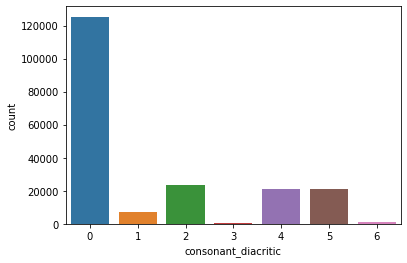

In [12]:
sns.countplot(x="consonant_diacritic", data=train_df)

 ## ラベル1つ1つを見ていく

In [13]:
# 以下のカーネルから借りてきた関数を使う
# https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn
def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

## grapheme_root

In [14]:
top_10_roots = get_n(train_df, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


In [15]:
bottom_10_roots = get_n(train_df, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


## vowel_diacritic

In [16]:
vowel_diacritic = get_n(train_df, 'vowel_diacritic', 11)
vowel_diacritic

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848
3,171,ী,16152
9,177,ো,16032
5,173,ূ,5297
6,174,ৃ,4336
10,178,ৌ,3563


In [17]:
consonant_diacritic = get_n(train_df, 'consonant_diacritic', 7)
consonant_diacritic

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424
6,185,্র্য,1387
3,182,র্য,619
